**Ce code a été éffectué dans le cadre d'un projet personnel réalisé par Alphonse EBROTIE , sur la période de Fin Novembre  2023 à fin Janvier 2024.**

**Dans cette partie il s'agit de l'implémentation des algorithmes de Q-learning et de SARSA .**

**Des détails techniques complémentaires sont fournis dans le rapport associé au projet .**

*Partie 1 : importation des librairies et definition de fonctions utiles pour la suite*

In [70]:
#Librairies utiles pour la suite utilisée 

#1.Librarie pour récupérer les données sur yahoo finance
#installer si ce n'est pas déjà fait , en enlevant le commentaire à la ligne suivante
#!pip install yfinance 

#2.Les autres librairies

import yfinance as yf
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
random.seed(2024)

*Quelques fonctions utiles*

In [71]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

#Quelques éléments utilisé dans la modélisation

class Portfolio():
    def __init__(self, initial_capital):
        self.initial_capital = initial_capital
        self.dates = []
        self.returns = []
        self.pos = [] # il s'agit des différentes positions :hold , buy,sell : 0,-1,1.
                
    def compute_return(self, data):
        ret_benchmark = data.pct_change()[1:]
        for i in range(len(ret_benchmark)):
            self.returns.append(self.pos[i] * ret_benchmark[i])
         
    def compute_price(self):
        cum_ret = (1 + np.array(self.returns)).cumprod() - 1
        self.price = self.initial_capital * (1 + cum_ret)
        
#fonction qui récupère les données sur yahoo finance :

def get_price(security, start_date, end_date, freq):
    return yf.download(tickers = security, start = start_date, end = end_date, interval = freq)['Adj Close']

def get_return(previous, current):
    ret = (current - previous) / previous
    if ret == -0.0:
        return 0.0
    else:
        return ret

#fonction qui donne l'état"

def get_state(pos, ret):
    return (pos, round(ret, 3))

#fonction pour calculer la récompense"

def compute_reward(ret, position):
    reward = ret * position
    if reward == -0.0:
        return 0.0
    else:
        return reward

*Partie 2 : Implémentation de l'algorithme Q-learning , cycle de training et de backtesting .*

*Implémentation de l'agent*

In [72]:
class Agent_Q:

    # On initialise les différents paramètres 
    
    def __init__(self, gamma, alpha):
        self.qValues = dict()
        self.gamma = gamma
        self.alpha = alpha
        self.actions = ['buy', 'sell', 'hold'] 
        """NB : hold : maintenir l'action précédente,
            si l'action précédente était d'acheter, nous restons long, si l'action précédente était de vendre,
            nous restons en dehors du marché
            buy : acheter
            sell : vendre
            """
    
    # rretourne la Q-value pour chaque paire état-action
    
    def getQValue(self, state, action):
        if (state, action) in self.qValues:
          return self.qValues[(state, action)]
        else:
          self.qValues[(state, action)] = 0.0
          return 0.0
      
    # Obtenir la valeur Q de l'action qui maximise un état spécifique
    
    def computeValueFromQValues(self, state):
        actions = self.actions
        max_val = max([self.getQValue(state, action) for action in actions])
        return max_val

    # Obtenir l'action qui maximise la Q-value pour un état donné
    def getAction(self, state):
        max_val = None
        max_action = None
        random.shuffle(self.actions)
        for action in self.actions:
          curr_val = self.getQValue(state, action)
          if max_val == None or max_val < curr_val:
            max_val = curr_val
            max_action = action
        return max_action

    # Mise à jour des valeurs selon l'algorithme
    
    def update(self, state, action, nextState, reward):
        state_val = self.getQValue(state, action)
        nextState_val = self.computeValueFromQValues(nextState)
        self.qValues[(state, action)] = state_val + self.alpha * (self.gamma * nextState_val - state_val + reward)

*Fonction d'entrainement de l'agent Q*

In [73]:

def train_agent_Q(data, qValues_table, training_parameters, model_parameters, context):
    
    # Initialisation
    
    pos = list()
    pos.append(0)
    Agent = Agent_Q(model_parameters.alpha, model_parameters.gamma)
    Agent.qValues = qValues_table
    
    for i in range(1, len(data) - 1):
        
        # rendement
        context.ret = get_return(data[i-1], data[i])
        
        # Mise à jour de l'action actuelle
        context.current_state = get_state(pos[-1], context.ret)
        
        # Explorer une action aléatoire avec probabilité epsilon (greedy-epsilon)
        
        epsilon = model_parameters.epsilon_parameter
        acceptance_probability = random.random()
        buy_arr = ['sell', 'hold']
        sell_arr = ['buy', 'hold']
        hold_arr = ['buy', 'sell']
        
        context.current_action = Agent.getAction(context.current_state)
        # Pour une action aléatoire donnée ,on explore l'ensemble de toutes les actions possibles 
        # afin de trouver celui qui est optimal pour l'algorithme  
        
        if acceptance_probability < epsilon:
            context.random_counter += 1
            if context.current_action == "buy":
                random.shuffle(buy_arr)
                context.current_action = buy_arr[0]
            elif context.current_action == "sell":
                random.shuffle(sell_arr)
                context.current_action = sell_arr[0]
            else:
                random.shuffle(hold_arr)
                context.current_action = hold_arr[0]
        
        # Mise à jour de l'agent
        if context.current_action == 'buy' and pos[-1] == 0:
            pos.append(1)
        elif context.current_action == 'buy' and pos[-1] == -1:
            pos.append(0)
        elif context.current_action == 'sell' and pos[-1] == 1:
            pos.append(0)
        elif context.current_action == 'sell' and pos[-1] == 0:
            pos.append(-1)
        else:
            context.current_action = 'hold'
            pos.append(pos[-1])
        
        ret_fut = get_return(data[i], data[i+1])
        state_temp = get_state(pos[-1], ret_fut)
        reward = compute_reward(ret_fut, pos[-1])
        Agent.update(
            context.current_state, 
            context.current_action, 
            state_temp, 
            reward
            )
        
        # mise à jour de l'action précédente
        
        context.previous_action = context.current_action
        
        # Compter le nombre d'occurrences d'un état
        if context.current_state in context.state_counter_dict:
            context.state_counter_dict[context.current_state] += 1
        else:
            context.state_counter_dict[context.current_state] = 0
            
        # Compter le nombre d'occurrences d'une action
        
        context.action_counter_dict[context.current_action] += 1
            
    return Agent.qValues

*Fonction de backtesting pour notre agent Q*

In [74]:
def backtesting_agent_Q(data, P, qValues_opt, backtest_parameters, model_parameters, context):
    
    P.dates = data.index
    P.pos.append(0) # parcequ'on suppose qu'on a que du cash au début dans le portefeuille
    Agent = Agent_Q(model_parameters.alpha, model_parameters.gamma)
    Agent.qValues = qValues_opt
    
    for i in range(1, len(data)):
        
        # rendement du portefeuille
        
        context.ret = get_return(data[i-1], data[i])
        
        # mise à jour 
        context.current_state = get_state(P.pos[-1], context.ret)
        
        # Explore a random action with probability epsilon (greedy-epsilon)
        epsilon = model_parameters.epsilon_parameter
        acceptance_probability = random.random()
        buy_arr = ['sell', 'hold']
        sell_arr = ['buy', 'hold']
        hold_arr = ['buy', 'sell']
        
        context.current_action = Agent.getAction(context.current_state)
        
        if acceptance_probability < epsilon:
            context.random_counter += 1
            if context.current_action == "buy":
                random.shuffle(buy_arr)
                context.current_action = buy_arr[0]
            elif context.current_action == "sell":
                random.shuffle(sell_arr)
                context.current_action = sell_arr[0]
            else:
                random.shuffle(hold_arr)
                context.current_action = hold_arr[0]
        
        # mise à jour
        if context.current_action == 'buy' and P.pos[-1] == 0:
            P.pos.append(1)
        elif context.current_action == 'buy' and P.pos[-1] == -1:
            P.pos.append(0)
        elif context.current_action == 'sell' and P.pos[-1] == 1:
            P.pos.append(0)
        elif context.current_action == 'sell' and P.pos[-1] == 0:
            P.pos.append(-1)
        else:
            context.current_action = 'hold'
            P.pos.append(P.pos[-1])
            
        state_temp = get_state(P.pos[-1], context.ret)
        reward = compute_reward(context.ret, P.pos[-1])
        Agent.update(
            context.current_state, 
            context.current_action, 
            state_temp, 
            reward
            )
        
        # mise à jour action precedente
        context.previous_action = context.current_action
        
        # occurence états
        if context.current_state in context.state_counter_dict:
            context.state_counter_dict[context.current_state] += 1
        else:
            context.state_counter_dict[context.current_state] = 0
            
        # occurence états
        context.action_counter_dict[context.current_action] += 1

*Partie 3 : Implémentation de l'algorithme SARSA , cycle de training et de backtesting .*

*Implémentation agent SARSA*

In [75]:
class Agent_SARSA:

    # initialisation
    def __init__(self, gamma, alpha):
        self.qValues = dict()
        self.gamma = gamma
        self.alpha = alpha
        self.actions = ['buy', 'sell', 'hold'] # idem que précédemment dans l'idée
        
    # Q-value pour la paire (état,action) :
    def getQValue(self, state, action):
        if (state, action) in self.qValues:
          return self.qValues[(state, action)]
        else:
          self.qValues[(state, action)] = 0.0
          return 0.0

    # Action qui donne une valeur maximale
    
    def getAction(self, state):
        max_val = None
        max_action = None
        random.shuffle(self.actions)
        for action in self.actions:
          curr_val = self.getQValue(state, action)
          if max_val == None or max_val < curr_val:
            max_val = curr_val
            max_action = action
        return max_action

    # mise à jour 
    
    def update(self, state, action, nextState, nextAction, reward):
        state_val = self.getQValue(state, action)
        nextState_val = self.getQValue(nextState, nextAction)
        self.qValues[(state, action)] = state_val + self.alpha * (self.gamma * nextState_val - state_val + reward)

*Fonction pour l'entrainement  de l'agent SARSA*

In [87]:
def train_agent_SARSA(data, qValues_table, training_parameters, model_parameters, context):
    
    # Initialisation
    pos = list()
    pos.append(0)
    Agent = Agent_SARSA(model_parameters.alpha, model_parameters.gamma)
    Agent.qValues = qValues_table
    
    for i in range(1, len(data) - 1):
        
        # rendement
        context.ret = get_return(data[i-1], data[i])
        
        # mise à jour 
        context.current_state = get_state(pos[-1], context.ret)
        
        # epsilon-greedy
        
        epsilon = model_parameters.epsilon_parameter
        acceptance_probability = random.random()
        buy_arr = ['sell', 'hold']
        sell_arr = ['buy', 'hold']
        hold_arr = ['buy', 'sell']
        
        context.current_action = Agent.getAction(context.current_state)
        
        if acceptance_probability < epsilon:
            context.random_counter += 1
            if context.current_action == "buy":
                random.shuffle(buy_arr)
                context.current_action = buy_arr[0]
            elif context.current_action == "sell":
                random.shuffle(sell_arr)
                context.current_action = sell_arr[0]
            else:
                random.shuffle(hold_arr)
                context.current_action = hold_arr[0]      
        
        # Mise à jour de l'agent
        if context.current_action == 'buy' and pos[-1] == 0:
            pos.append(1)
        elif context.current_action == 'buy' and pos[-1] == -1:
            pos.append(0)
        elif context.current_action == 'sell' and pos[-1] == 1:
            pos.append(0)
        elif context.current_action == 'sell' and pos[-1] == 0:
            pos.append(-1)
        else:
            context.current_action = 'hold'
            pos.append(pos[-1])
            
        ret_fut = get_return(data[i], data[i+1])
        state_temp = get_state(pos[-1], ret_fut)
        action_temp = Agent.getAction(state_temp)
        if acceptance_probability < epsilon:
            context.random_counter += 1
            if action_temp == "buy":
                random.shuffle(buy_arr)
                action_temp = buy_arr[0]
            elif action_temp == "sell":
                random.shuffle(sell_arr)
                action_temp = sell_arr[0]
            else:
                random.shuffle(hold_arr)
                action_temp = hold_arr[0]
        reward = compute_reward(ret_fut, pos[-1])
        Agent.update(
            context.current_state, 
            context.current_action, 
            state_temp, 
            action_temp,
            reward
            )
        
        # mise à jour de l'action
        context.previous_action = context.current_action
        
        
        if context.current_state in context.state_counter_dict:
            context.state_counter_dict[context.current_state] += 1
        else:
            context.state_counter_dict[context.current_state] = 0
            
        
        context.action_counter_dict[context.current_action] += 1
            
    return Agent.qValues

*Fonction pour backtesting SARSA*

In [88]:
def backtesting_agent_SARSA(data, P, qValues_opt, backtest_parameters, model_parameters, context):
    
    ### Initialize
    P.dates = data.index
    P.pos.append(0) # because we suppose that we have only cash in the portfolio at the beginning
    Agent = Agent_SARSA(model_parameters.alpha, model_parameters.gamma)
    Agent.qValues = qValues_opt
    
    for i in range(1, len(data)):
        
        # Get the return
        context.ret = get_return(data[i-1], data[i])
        
        # Update current state
        context.current_state = get_state(P.pos[-1], context.ret) # state = (pos, round(log(ret)), 3)
        
        # Explore a random action with probability epsilon (greedy-epsilon)
        epsilon = model_parameters.epsilon_parameter
        acceptance_probability = random.random()
        buy_arr = ['sell', 'hold']
        sell_arr = ['buy', 'hold']
        hold_arr = ['buy', 'sell']
        
        context.current_action = Agent.getAction(context.current_state)
        # We choose a random action to explore other action than the one that maximize the SARSA algorithm or or we choose the action that maximize the SARSA algorithm
        if acceptance_probability < epsilon:
            context.random_counter += 1
            if context.current_action == "buy":
                random.shuffle(buy_arr)
                context.current_action = buy_arr[0]
            elif context.current_action == "sell":
                random.shuffle(sell_arr)
                context.current_action = sell_arr[0]
            else:
                random.shuffle(hold_arr)
                context.current_action = hold_arr[0]
            
        # Update the agent
        if context.current_action == 'buy' and P.pos[-1] == 0:
            P.pos.append(1)
        elif context.current_action == 'buy' and P.pos[-1] == -1:
            P.pos.append(0)
        elif context.current_action == 'sell' and P.pos[-1] == 1:
            P.pos.append(0)
        elif context.current_action == 'sell' and P.pos[-1] == 0:
            P.pos.append(-1)
        else:
            context.current_action = 'hold'
            P.pos.append(P.pos[-1])
            
        state_temp = get_state(P.pos[-1], context.ret)
        action_temp = Agent.getAction(state_temp)
        # We choose a random action to explore other action than the one that maximize the SARSA algorithm or we choose the action that maximize the SARSA algorithm
        if acceptance_probability < epsilon:
            context.random_counter += 1
            if action_temp == "buy":
                random.shuffle(buy_arr)
                action_temp = buy_arr[0]
            elif action_temp == "sell":
                random.shuffle(sell_arr)
                action_temp = sell_arr[0]
            else:
                random.shuffle(hold_arr)
                action_temp = hold_arr[0]
        
        reward = compute_reward(context.ret, P.pos[-1])
        Agent.update(
            context.current_state, 
            context.current_action, 
            state_temp, 
            action_temp,
            reward
            )
            
        # Mise à jour action precedente
        context.previous_action = context.current_action
            
        # nombre occurence état
        if context.current_state in context.state_counter_dict:
            context.state_counter_dict[context.current_state] += 1
        else:
            context.state_counter_dict[context.current_state] = 0
                
        # nombre occurence action
        context.action_counter_dict[context.current_action] += 1

*Partie 4 : Application numérique*

*Entrainement Q-learning*

In [79]:
model_parameters = AttrDict() # paramètres du modèle
args_dict = {
        'alpha' : 0.3, # learning rate
        'gamma' : 0.9, # coefficient gamma
        'epsilon_parameter' : 0.1, # epsilon de la méthode epsilon-greedy  
        }
model_parameters.update(args_dict)

training_parameters = AttrDict() # paramètres de train
args_dict = {
        'security' : '^GSPC', 
        'start_date' : None,
        'end_date' : '2020-12-31',
        'frequency' : '1d',
        'epoch' : 50
        }
training_parameters.update(args_dict)

data = get_price(training_parameters.security, training_parameters.start_date, training_parameters.end_date, training_parameters.frequency)
qValues_table = dict()
for _ in range(training_parameters.epoch):
    
    context = AttrDict() 
    args_dict = {
            'ret' : 0,
            'current_state' : None,
            'previous_action' : 'hold', # on suppose qu'on est en hold en tout début
            'current_action' : None,
            'state_counter_dict' : dict(),
            'action_counter_dict' : dict({'buy' : 0, 'sell' : 0, 'hold' : 0}),
            'random_counter' : 0
            }
    context.update(args_dict)
    
    qValues_table = train_agent_Q(data, qValues_table, training_parameters, model_parameters, context)
    sys.stdout.write(
            "\r[Epoch %d/%d]"
            % (
                _,
                training_parameters.epoch)
            )

qValues_opt_Q = qValues_table

[*********************100%%**********************]  1 of 1 completed
[Epoch 49/50]

*Entrainement SARSA*

In [118]:
model_parameters = AttrDict()
args_dict = {
        'alpha' : 0.3, 
        'gamma' : 0.9, 
        'epsilon_parameter' : 0.1, 
        }
model_parameters.update(args_dict)

training_parameters = AttrDict() 
args_dict = {
        'security' : '^GSPC', 
        'start_date' : None,
        'end_date' : '2018-12-31',
        'frequency' : '1d',
        'epoch' : 50
        }
training_parameters.update(args_dict)

data = get_price(training_parameters.security, training_parameters.start_date, training_parameters.end_date, training_parameters.frequency)
qValues_table = dict()
for _ in range(training_parameters.epoch):
    
    context = AttrDict() 
    args_dict = {
            'ret' : 0,
            'current_state' : None,
            'previous_action' : 'hold', 
            'current_action' : None, 
            'state_counter_dict' : dict(),
            'action_counter_dict' : dict({'buy' : 0, 'sell' : 0, 'hold' : 0}),
            'random_counter' : 0
            }
    context.update(args_dict)
    
    qValues_table = train_agent_SARSA(data, qValues_table, training_parameters, model_parameters, context)
    sys.stdout.write(
            "\r[Epoch %d/%d]"
            % (
                _,
                training_parameters.epoch)
            )

qValues_opt_SARSA = qValues_table

[*********************100%%**********************]  1 of 1 completed
[Epoch 49/50]

*Backtesting pour le Q-learning*

[*********************100%%**********************]  1 of 1 completed


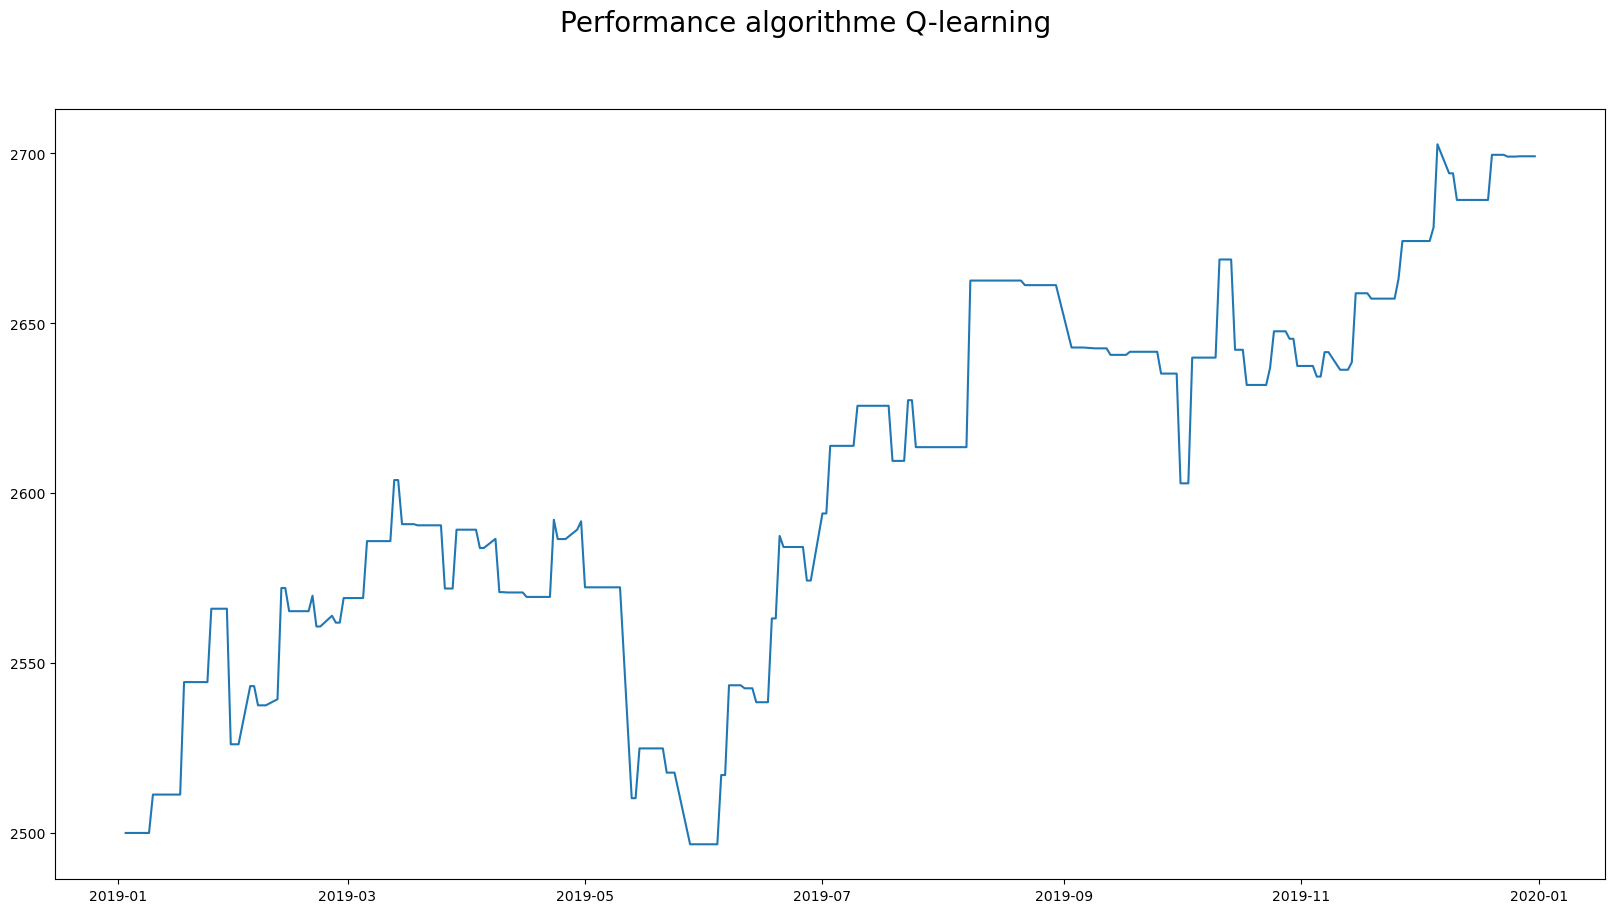

In [138]:
#benchmark = get_price('^GSPC','2019-01-01' ,'2020-01-01','1d')  

model_parameters = AttrDict() 
args_dict = {
        'alpha' : 0.2, 
        'gamma' : 0.9, 
        'epsilon_parameter' : 0.01, 
        }
model_parameters.update(args_dict)
    
backtesting_parameters = AttrDict() 


args_dict = {
        'security' : '^GSPC', 
        'start_date' : '2019-01-01', # format yyyy-mm-dd
        'end_date' : '2020-01-01', # format yyyy-mm-dd
        'frequency' : '1d', # quotidien
        'initial_capital' : 2500, # capital initial
        }
backtesting_parameters.update(args_dict)
  
context = AttrDict()  
args_dict = {
        'ret' : 0,
        'current_state' : None,
        'previous_action' : 'hold', 
        'current_action' : None,
        'state_counter_dict' : dict(),
        'action_counter_dict' : dict({'buy' : 0, 'sell' : 0, 'hold' : 0}),
        'random_counter' : 0
        }
context.update(args_dict)
    
data = get_price(backtesting_parameters.security, backtesting_parameters.start_date, backtesting_parameters.end_date, backtesting_parameters.frequency)
P_Q = Portfolio(initial_capital = backtesting_parameters.initial_capital)
backtesting_agent_Q(data, P_Q, qValues_opt_Q, backtesting_parameters, model_parameters, context)
P_Q.compute_return(data)
P_Q.compute_price()

# Performance avec l'algorithme Q-Learning

fig = plt.figure(figsize=(20,10))
fig.suptitle('Performance algorithme Q-learning', fontsize = 20)
plt.plot(P_Q.dates[1:], P_Q.price)

*Comparaison avec le benchmark*

In [159]:
# Comparaison avec le benchmarck

benchmark = get_price(backtesting_parameters.security, backtesting_parameters.start_date, backtesting_parameters.end_date, backtesting_parameters.frequency)
nbre_jours_de_trading=252
ret_benchmark = pd.DataFrame(benchmark).pct_change()[1:]
ret_ptf = pd.DataFrame(P_Q.price).pct_change()[1:]

ret_annualized_benchmark = np.mean(ret_benchmark)*nbre_jours_de_trading
ret_annualized_ptf = np.mean(ret_ptf)*nbre_jours_de_trading

vol_annualized_benchmark = np.std(ret_benchmark) * np.sqrt(nbre_jours_de_trading)
vol_annualized_ptf = np.std(ret_ptf) * np.sqrt(nbre_jours_de_trading)

sharpe_ratio_benchmark = ret_annualized_benchmark / vol_annualized_benchmark
sharpe_ratio_ptf = ret_annualized_ptf / vol_annualized_ptf

result = pd.DataFrame(data = [[ret_annualized_benchmark[0], ret_annualized_ptf[0]], 
                              [vol_annualized_benchmark[0], vol_annualized_ptf[0]],
                              [sharpe_ratio_benchmark[0], sharpe_ratio_ptf[0]]],
                     columns = ['Benchmark', 'Portefeuille Q'],
                     index = ['Rendement annualisé', 'Volatilité annualisé', 'Sharpe Ratio'])
print(result)

[*********************100%%**********************]  1 of 1 completed
                      Benchmark  Portefeuille Q
Rendement annualisé    0.261357        0.079144
Volatilité annualisé   0.124720        0.061090
Sharpe Ratio           2.095539        1.295547


c:\Users\alpho\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
c:\Users\alpho\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


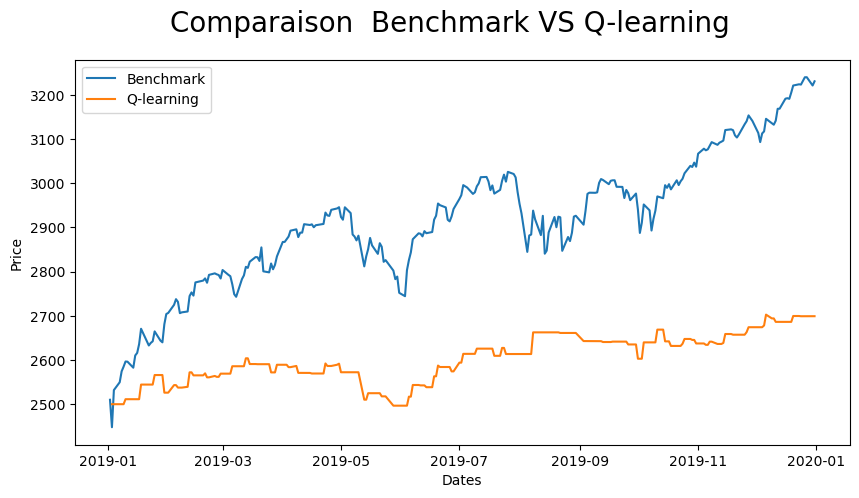

In [141]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,5))
fig.suptitle('Comparaison  Benchmark VS Q-learning', fontsize=20)

ax = fig.add_subplot(111)
ax.set_xlabel('Dates')
ax.set_ylabel('Prix')

ax.plot(benchmark.index, benchmark, label='Benchmark')  

portfolio_dates = P_Q.dates[1:] 
portfolio_prices = P_Q.price  
ax.plot(portfolio_dates, portfolio_prices, label='Q-learning')

ax.legend()

plt.show()


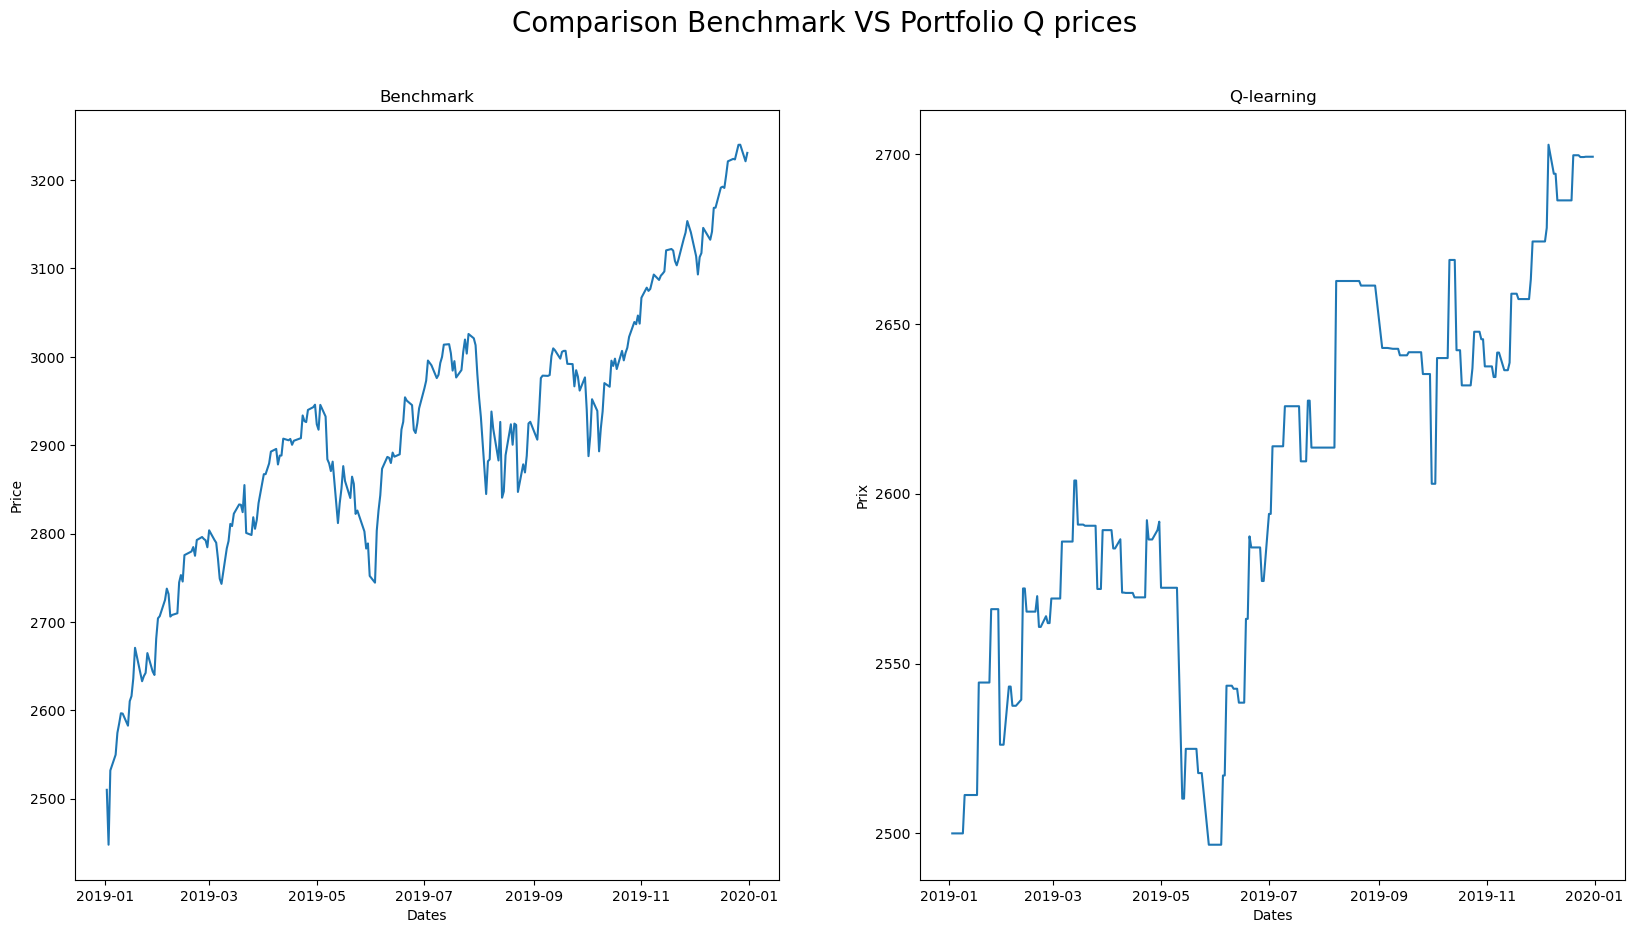

In [142]:
fig = plt.figure(figsize=(20,10))
fig.suptitle('Comparison Benchmark VS Portfolio Q prices', fontsize = 20)
ax1 = plt.subplot(121)
ax1.title.set_text('Benchmark')
ax1.set_xlabel('Dates')
ax1.set_ylabel('Prix')
plt.plot(benchmark.index, benchmark)
ax2 = plt.subplot(122)
ax2.title.set_text('Q-learning')
ax2.set_xlabel('Dates')
ax2.set_ylabel('Prix')
plt.plot(P_Q.dates[1:], P_Q.price)

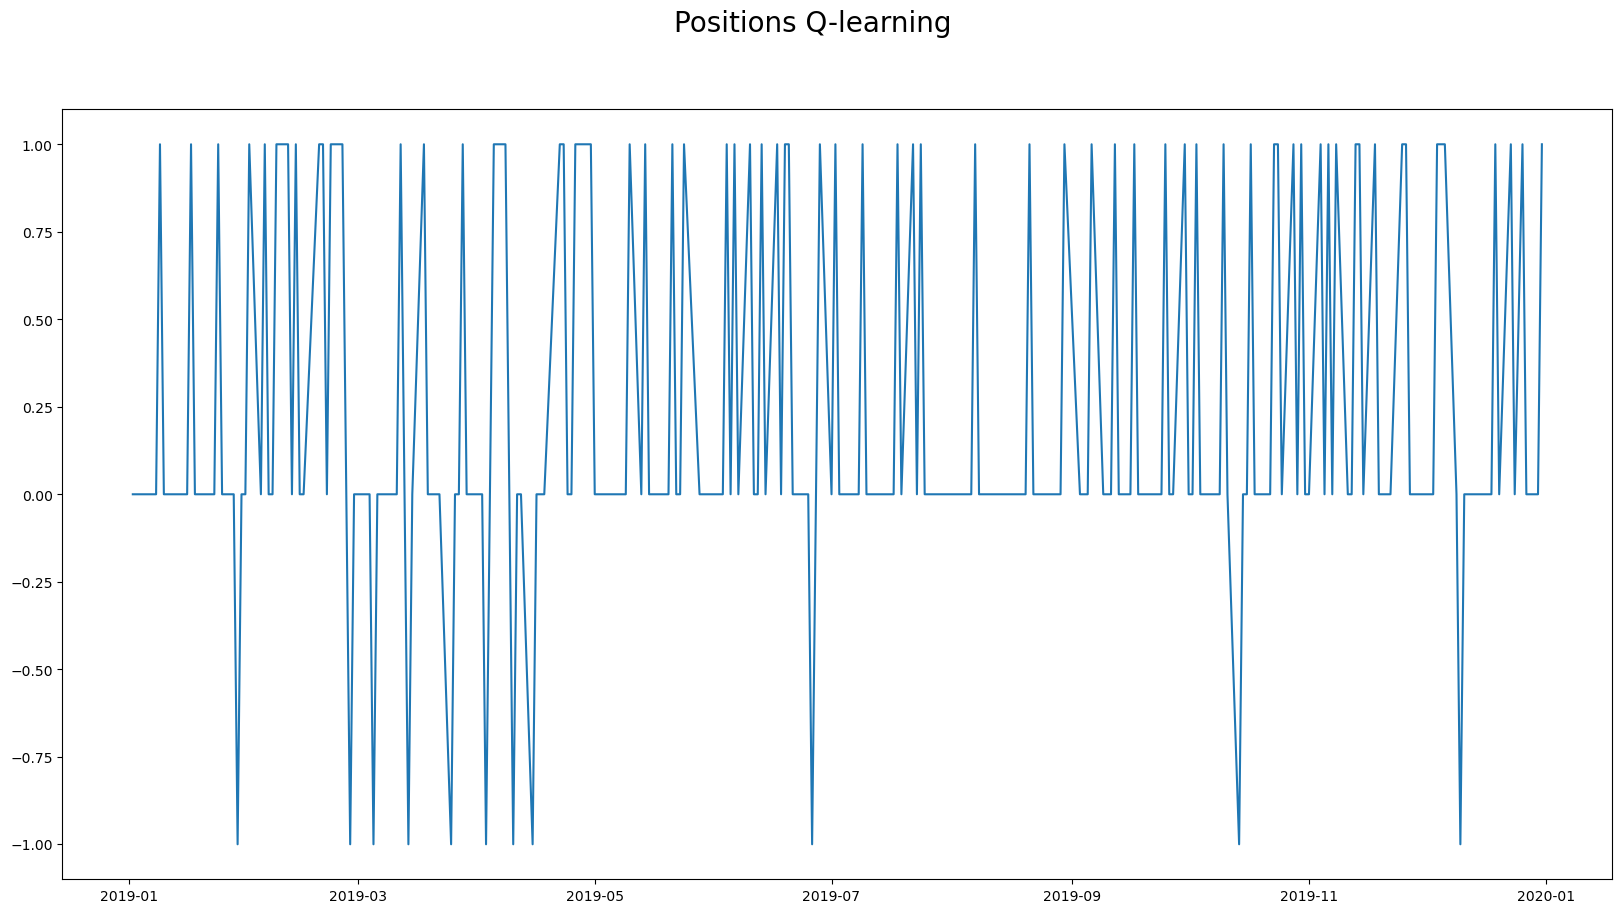

In [143]:
# Positions

fig = plt.figure(figsize=(20,10))
fig.suptitle('Positions Q-learning', fontsize = 20)
plt.plot(P_Q.dates, P_Q.pos)

*Backtesting avec l'algorithme SARSA*

[*********************100%%**********************]  1 of 1 completed


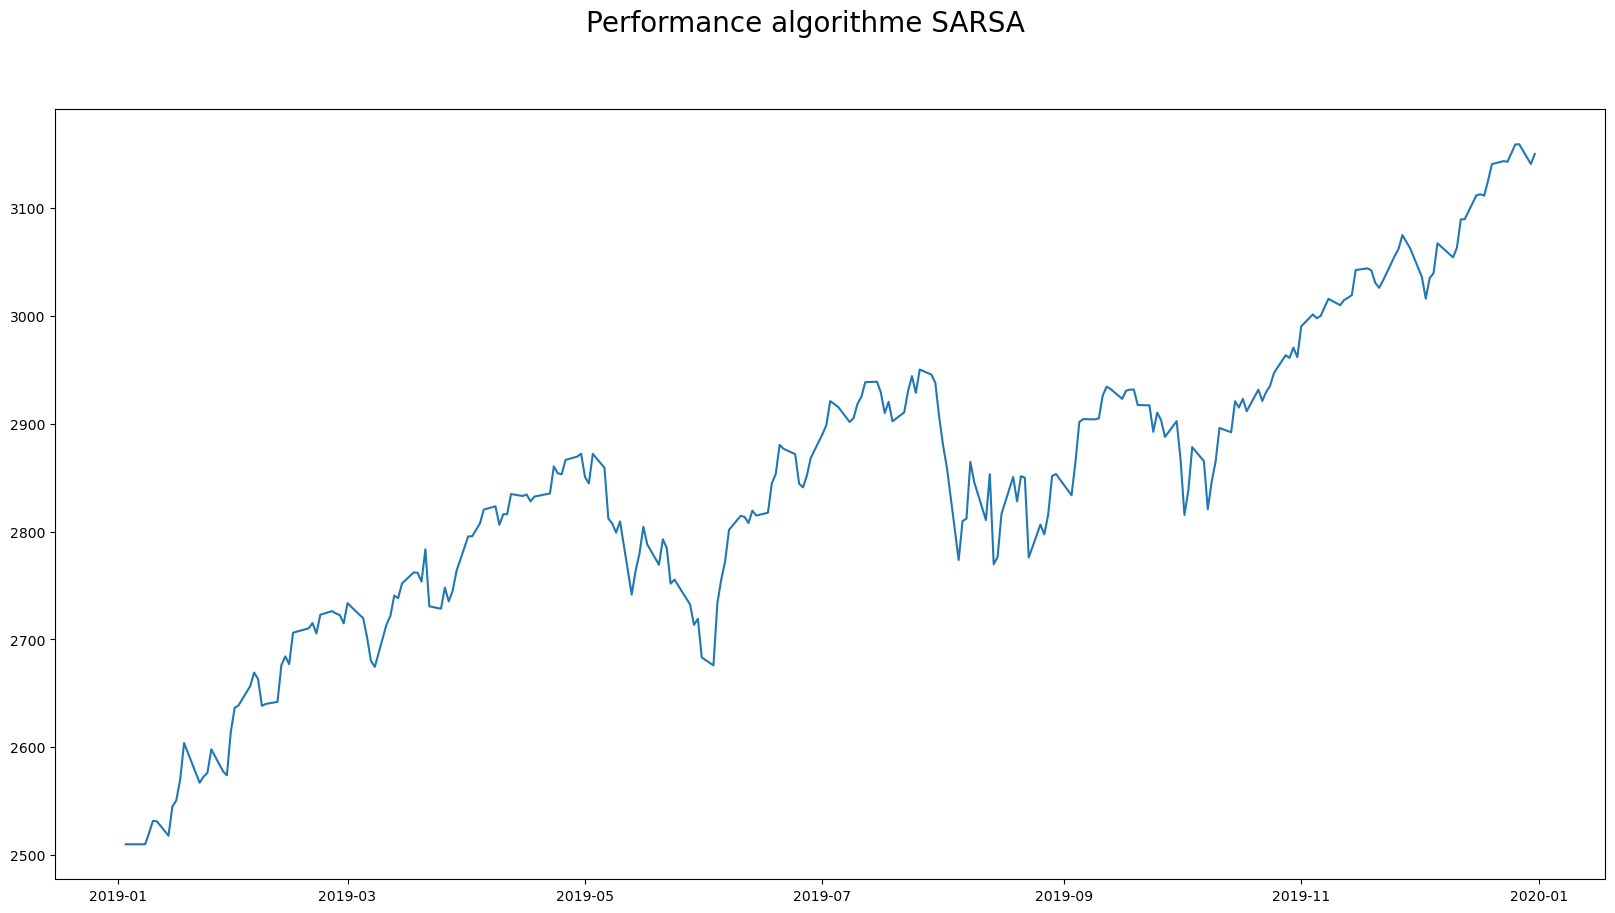

In [147]:
model_parameters = AttrDict() 
args_dict = {
        'alpha' : 0.3, 
        'gamma' : 0.9, 
        'epsilon_parameter' : 0.01, 
        }
model_parameters.update(args_dict)
    
backtesting_parameters = AttrDict() 
args_dict = {
        'security' : '^GSPC', 
        'start_date' : '2019-01-01', # format yyyy-mm-dd
        'end_date' : '2020-01-01', # format yyyy-mm-dd
        'frequency' : '1d', # quotidien
        'initial_capital' : benchmark[0], # capital initial pour le backtesting
        }
backtesting_parameters.update(args_dict)
    
context = AttrDict() 
args_dict = {
        'ret' : 0,
        'current_state' : None, 
        'previous_action' : 'hold', 
        'current_action' : None,
        'state_counter_dict' : dict(),
        'action_counter_dict' : dict({'buy' : 0, 'sell' : 0, 'hold' : 0}),
        'random_counter' : 0
        }
context.update(args_dict)

data = get_price(backtesting_parameters.security, backtesting_parameters.start_date, backtesting_parameters.end_date, backtesting_parameters.frequency)
P_SARSA = Portfolio(initial_capital = backtesting_parameters.initial_capital)
backtesting_agent_SARSA(data, P_SARSA, qValues_opt_SARSA, backtesting_parameters, model_parameters, context)
P_SARSA.compute_return(data)
P_SARSA.compute_price()

# Performance de notre portefeuille avec l'algorithme SARSA

fig = plt.figure(figsize=(20,10))
fig.suptitle('Performance algorithme SARSA', fontsize = 20)
plt.plot(P_SARSA.dates[1:], P_SARSA.price)

In [160]:
# Comparaison avec le benchmark

benchmark = get_price(backtesting_parameters.security, backtesting_parameters.start_date, backtesting_parameters.end_date, backtesting_parameters.frequency)

ret_benchmark = pd.DataFrame(benchmark).pct_change()[1:]
ret_ptf = pd.DataFrame(P_SARSA.price).pct_change()[1:]

ret_annualized_benchmark = np.mean(ret_benchmark)*nbre_jours_de_trading
ret_annualized_ptf = np.mean(ret_ptf)*nbre_jours_de_trading

vol_annualized_benchmark = np.std(ret_benchmark) * np.sqrt(nbre_jours_de_trading)
vol_annualized_ptf = np.std(ret_ptf) * np.sqrt(nbre_jours_de_trading)

sharpe_ratio_benchmark = ret_annualized_benchmark / vol_annualized_benchmark
sharpe_ratio_ptf = ret_annualized_ptf / vol_annualized_ptf

result = pd.DataFrame(data = [[ret_annualized_benchmark[0], ret_annualized_ptf[0]], 
                              [vol_annualized_benchmark[0], vol_annualized_ptf[0]],
                              [sharpe_ratio_benchmark[0], sharpe_ratio_ptf[0]]],
                     columns = ['Benchmark', 'Portefeuille SARSA'],
                     index = ['Rendement annualisé', 'Volatilité annualisé', 'Sharpe Ratio'])
print(result)

[*********************100%%**********************]  1 of 1 completed


                      Benchmark  Portefeuille SARSA
Rendement annualisé    0.261357            0.235907
Volatilité annualisé   0.124720            0.117125
Sharpe Ratio           2.095539            2.014149


c:\Users\alpho\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
c:\Users\alpho\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


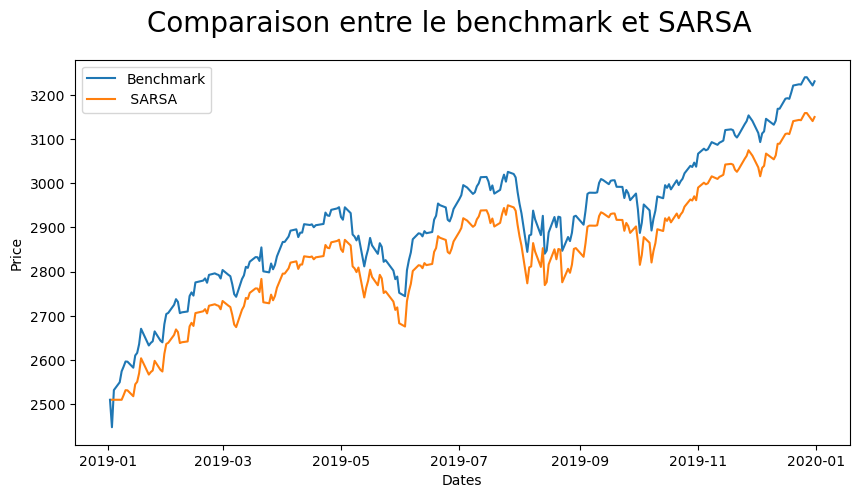

In [156]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,5))
fig.suptitle('Comparaison entre le benchmark et SARSA', fontsize=20)

ax = fig.add_subplot(111)
ax.set_xlabel('Dates')
ax.set_ylabel('Price')


ax.plot(benchmark.index, benchmark, label='Benchmark') 
portfolio_dates = P_SARSA.dates[1:] 
portfolio_prices = P_SARSA.price  
ax.plot(portfolio_dates, portfolio_prices, label=' SARSA')

ax.legend()

plt.show()


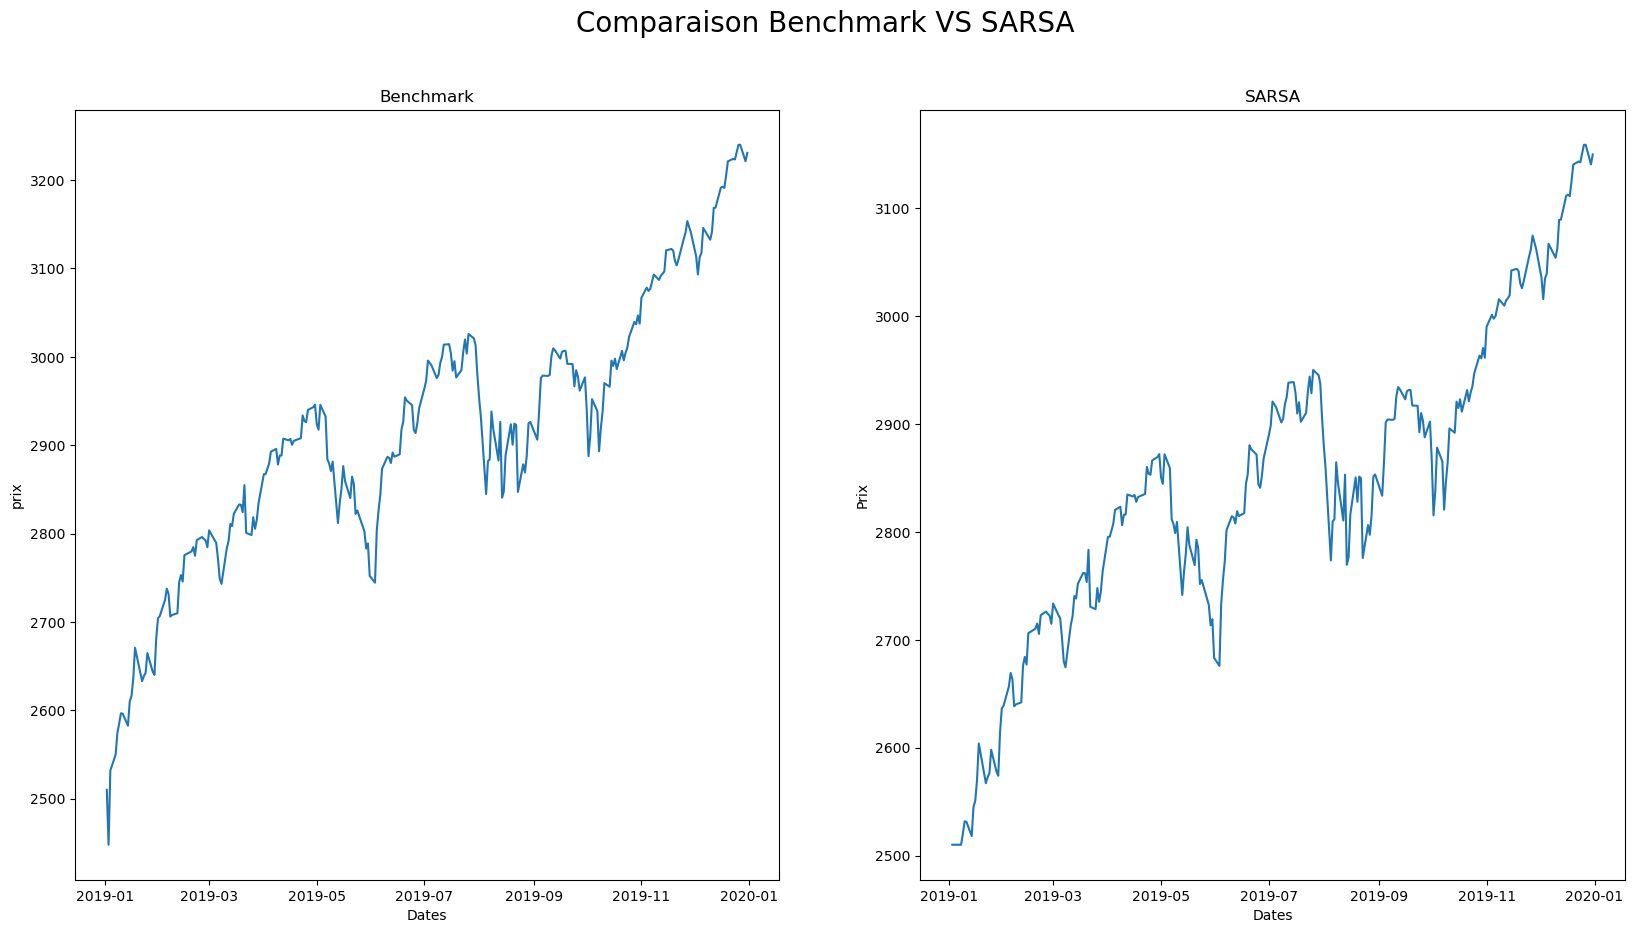

In [157]:
fig = plt.figure(figsize=(20,10))
fig.suptitle('Comparaison Benchmark VS SARSA', fontsize = 20)
ax1 = plt.subplot(121)
ax1.title.set_text('Benchmark')
ax1.set_xlabel('Dates')
ax1.set_ylabel('prix')
plt.plot(benchmark.index, benchmark)
ax2 = plt.subplot(122)
ax2.title.set_text('SARSA')
ax2.set_xlabel('Dates')
ax2.set_ylabel('Prix')
plt.plot(P_SARSA.dates[1:], P_SARSA.price)

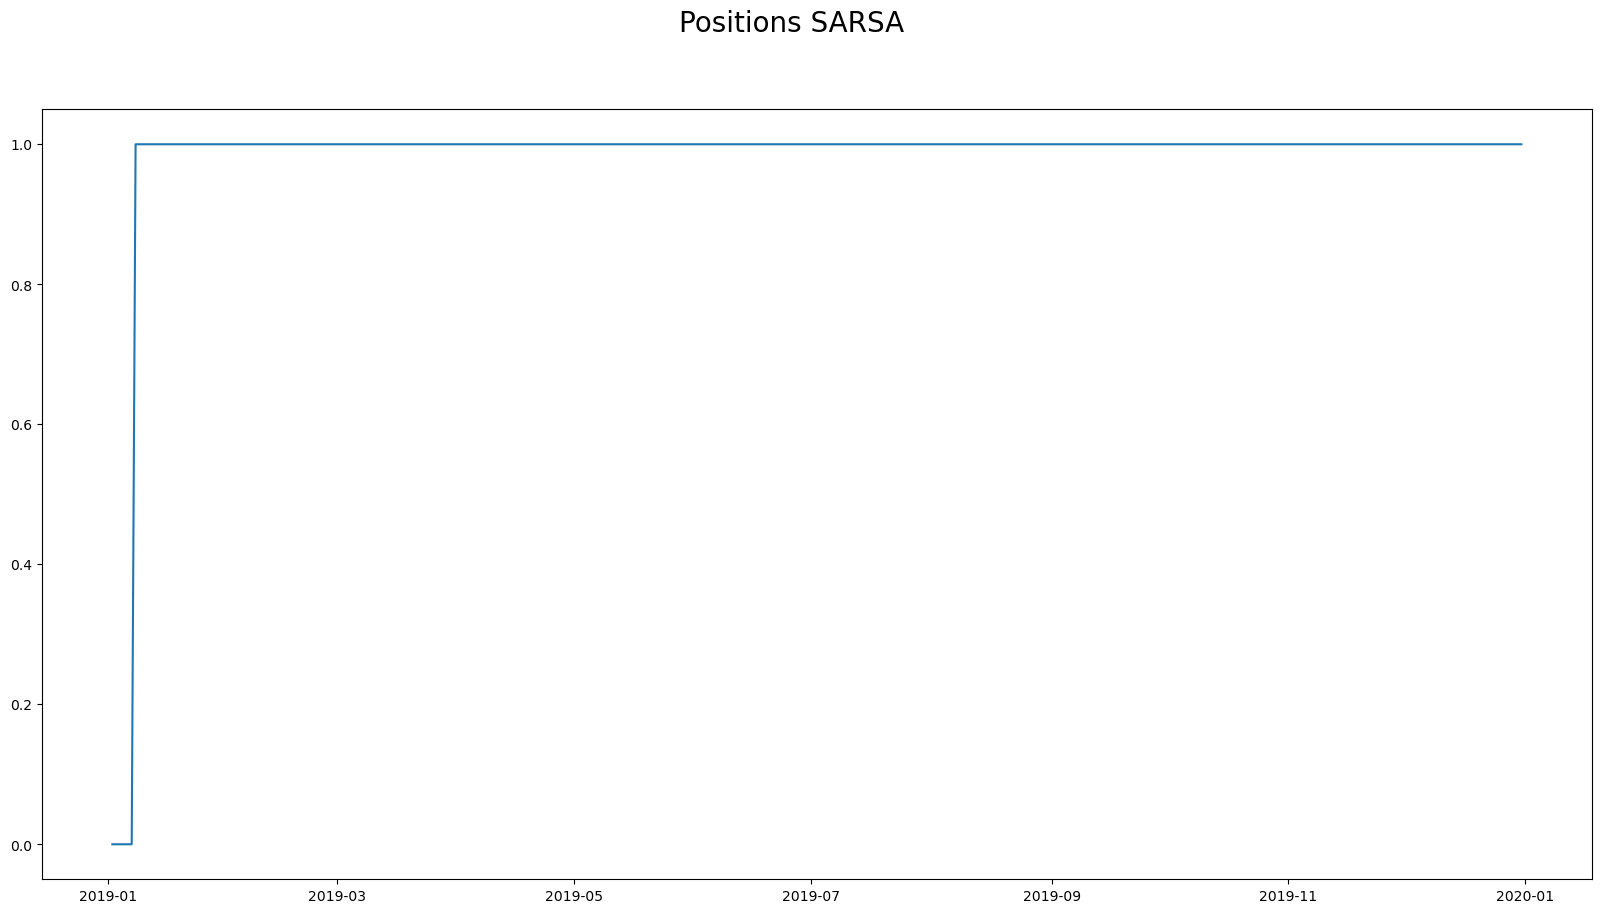

In [158]:
# Positions

fig = plt.figure(figsize=(20,10))
fig.suptitle('Positions SARSA', fontsize = 20)
plt.plot(P_SARSA.dates, P_SARSA.pos)